# EMA Trend Following Strategy

In [1]:
import sys
from pathlib import Path

import matplotlib
if not hasattr(matplotlib.rcParams, '_get'):
    matplotlib.rcParams._get = matplotlib.rcParams.get

import matplotlib.pyplot as plt
import pandas as pd

project_root = Path('..').resolve()
src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from data_loader import load_ohlcv_csv
from indicators import calculate_ema
from strategy import ema_vs_price_signals
from backtest import run_backtest
from qflib_metrics import qflib_metrics_from_returns


In [2]:
df = load_ohlcv_csv('../data/OKX_BTCUSDT, 1D.csv')
df.head()


,open,high,low,close,EMA,Oversold HWO Up,Overbought HWO Down,HWO Up,HWO Down,ATR,MACD,Signal
time,,,,,,,,,,,,
2025-01-17 00:00:00+00:00,99990.9,105847.4,99950.1,104084.4,87477.819959,NaN,NaN,NaN,NaN,3858.413818,806.234733,45.098916
2025-01-18 00:00:00+00:00,104084.5,104984.0,102288.0,104551.6,87780.010756,NaN,NaN,NaN,NaN,3775.384260,1263.568044,288.792741
2025-01-19 00:00:00+00:00,104551.6,106448.6,99639.4,101334.0,88019.904371,NaN,NaN,NaN,NaN,3992.085384,1350.803339,501.194861
2025-01-20 00:00:00+00:00,101334.0,109800.0,99526.4,102264.3,88272.017568,NaN,NaN,NaN,78.924812,4440.765000,1477.968275,696.549544
2025-01-21 00:00:00+00:00,102263.9,107285.8,100111.0,106150.1,88588.443806,NaN,NaN,NaN,NaN,4636.053214,1870.734327,931.386500


In [3]:
df['EMA50'] = calculate_ema(df['close'], 50)
df[['close', 'EMA50']].tail()


,close,EMA50
time,,
2025-11-08 00:00:00+00:00,102320.1,110647.271021
2025-11-09 00:00:00+00:00,104722.4,110414.923137
2025-11-10 00:00:00+00:00,106012.0,110242.259485
2025-11-11 00:00:00+00:00,103061.7,109960.668917
2025-11-12 00:00:00+00:00,103274.7,109698.474057


In [4]:
positions = ema_vs_price_signals(df, 'EMA50')
positions.value_counts()


position
0    151
1    149
Name: count, dtype: int64

In [5]:
bt = run_backtest(df.copy(), positions)
bt[['close', 'strategy_ret', 'equity_curve']].tail()


,close,strategy_ret,equity_curve
time,,,
2025-11-08 00:00:00+00:00,102320.1,-0.0,10414.404917
2025-11-09 00:00:00+00:00,104722.4,0.0,10414.404917
2025-11-10 00:00:00+00:00,106012.0,0.0,10414.404917
2025-11-11 00:00:00+00:00,103061.7,-0.0,10414.404917
2025-11-12 00:00:00+00:00,103274.7,0.0,10414.404917


In [6]:
metrics = qflib_metrics_from_returns(bt['strategy_ret'])
metrics_df = pd.DataFrame([metrics], index=['EMA_50'])
metrics_df


,total_return,cagr,sharpe_ratio,annualised_vol,max_drawdown,avg_drawdown_duration
EMA_50,0.04144,0.034696,0.271125,0.197657,-0.146291,28.4


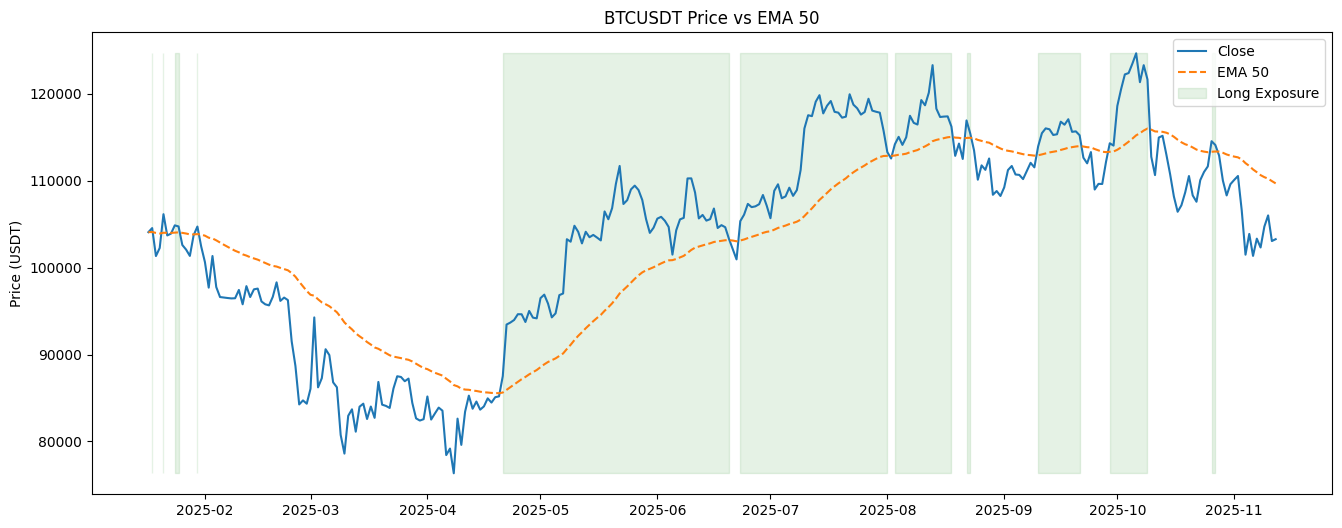

In [7]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df.index, df['close'], label='Close')
ax.plot(df.index, df['EMA50'], label='EMA 50', linestyle='--')
ax.fill_between(
    df.index,
    df['close'].min(),
    df['close'].max(),
    where=positions > 0.5,
    color='green',
    alpha=0.1,
    label='Long Exposure',
)
ax.set_title('BTCUSDT Price vs EMA 50')
ax.set_ylabel('Price (USDT)')
ax.legend()
plt.show()


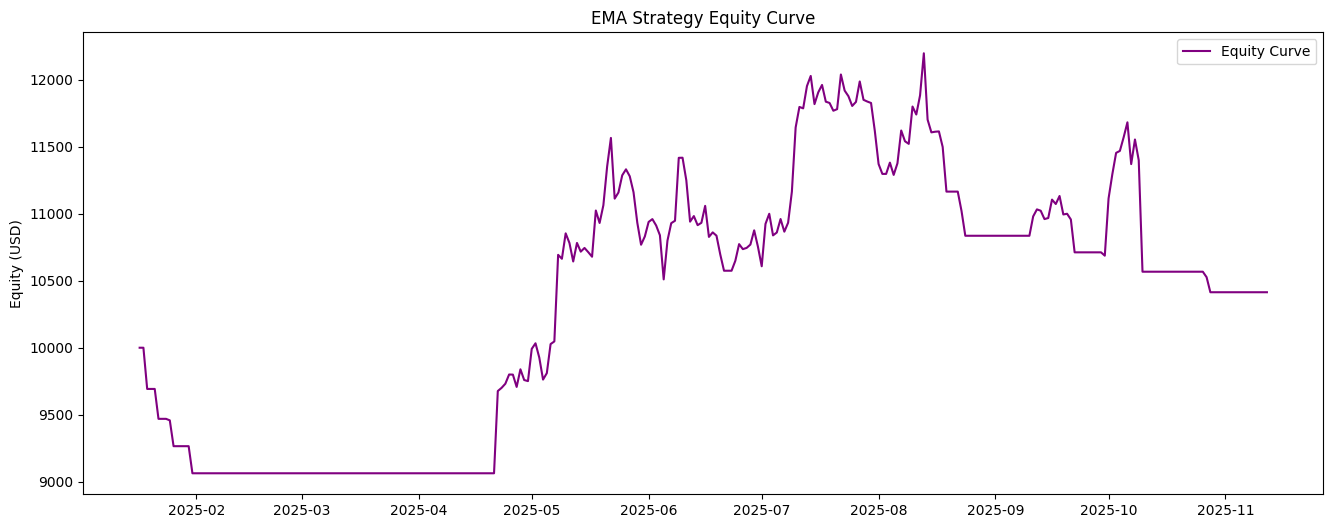

In [8]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(bt.index, bt['equity_curve'], label='Equity Curve', color='purple')
ax.set_title('EMA Strategy Equity Curve')
ax.set_ylabel('Equity (USD)')
ax.legend()
plt.show()
